In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.inference import inference
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode
from dust3r.model import AsymmetricCroCo3DStereo

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


/Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/dust3r-main/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/Volumes/HomeX/Applications/anaconda3/envs/dust3r/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import argparse 
from torch.serialization import add_safe_globals

add_safe_globals([argparse.Namespace])

In [4]:
# Frame Extraction
def extract_multiple_frames(video_path, frame_indices, out_dir="frames"):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    count = 0
    paths = []

    while success:
        if count in frame_indices:
            path = os.path.join(out_dir, f"frame{count}.png")
            cv2.imwrite(path, frame)
            paths.append(path)
            if len(paths) == len(frame_indices):
                break
        success, frame = cap.read()
        count += 1
    cap.release()
    return paths

# Scene Reconstruction from Multiple Frames
def process_multiple_frames(frame_paths, model, device, batch_size, niter, schedule, lr):

    # Load frames into memory and resize
    images = load_images(frame_paths, size=512)

    # Create all possible image pairs
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)

    # Run inference to get predictions
    output = inference(pairs, model, device, batch_size=batch_size)

    # Align scene globally for 3D reconstruction
    scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
    scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)
    return scene

# Geometric Consistency Loss (Pairwise from Global Scene)
def compute_geometric_consistency_loss(scene, idx1, idx2, lambda_rgb=2.5, huber_delta=2.0):

    # Extract scene components
    imgs = scene.imgs
    focals = scene.get_focals()
    poses = scene.get_im_poses()
    pts3d = scene.get_pts3d()
    confidence_masks = scene.get_masks()

    # Build intrinsic matrix using focal length
    f = focals[idx1].detach().cpu().numpy().item()
    H, W = imgs[idx1].shape[:2]
    K = np.array([[f, 0, W / 2], [0, f, H / 2], [0, 0, 1]])

    # Extract and convert extrinsics to world coordinates
    pose1 = poses[idx1]
    pose2 = poses[idx2]
    T1 = np.linalg.inv(pose1.detach().cpu().numpy())
    T2 = np.linalg.inv(pose2.detach().cpu().numpy())
    R1, t1 = T1[:3, :3], T1[:3, 3]
    R2, t2 = T2[:3, :3], T2[:3, 3]
    R_rel = R2 @ R1.T
    t_rel = t2 - R_rel @ t1

    # Compute the fundamental matrix from the relative pose
    t_x = np.array([[0, -t_rel[2], t_rel[1]], [t_rel[2], 0, -t_rel[0]], [-t_rel[1], t_rel[0], 0]])
    F = np.linalg.inv(K).T @ t_x @ R_rel @ np.linalg.inv(K)

    # Get corresponding 2D and 3D points (based on the confidence map on points)
    from dust3r.utils.geometry import xy_grid, find_reciprocal_matches
    pts2d_list, pts3d_list = [], []
    for i in [idx1, idx2]:
        conf_i = confidence_masks[i].cpu().numpy()
        pts2d_list.append(xy_grid(*imgs[i].shape[:2][::-1])[conf_i])
        pts3d_list.append(pts3d[i].detach().cpu().numpy()[conf_i])

    # Find mutual nearest 3D matches between frames
    reciprocal_in_P2, nn2_in_P1, _ = find_reciprocal_matches(*pts3d_list)
    matches_im1 = pts2d_list[1][reciprocal_in_P2]
    matches_im0 = pts2d_list[0][nn2_in_P1][reciprocal_in_P2]

    # Convert points to homogeneous coordinates for epipolar geometry
    matches_im0_h = np.concatenate([matches_im0, np.ones((matches_im0.shape[0], 1))], axis=1)
    matches_im1_h = np.concatenate([matches_im1, np.ones((matches_im1.shape[0], 1))], axis=1)

    # Compute epipolar lines in both images
    lines_in_im1 = (F @ matches_im0_h.T).T
    lines_in_im0 = (F.T @ matches_im1_h.T).T

    def point_line_dist(lines, points_h):
        num = np.abs(np.sum(lines * points_h, axis=1))
        denom = np.sqrt(lines[:, 0]**2 + lines[:, 1]**2) + 1e-8
        return num / denom

    d1 = point_line_dist(lines_in_im1, matches_im1_h)
    d0 = point_line_dist(lines_in_im0, matches_im0_h)
    epipolar_distances = d0 + d1

    def huber(x, delta=huber_delta):
        return np.where(np.abs(x) < delta,
                        0.5 * x**2,
                        delta * (np.abs(x) - 0.5 * delta))

    rho = huber(epipolar_distances)

    # Sample corresponding RGB pixels
    def sample_rgb(img, coords):
        coords = np.clip(coords.round().astype(int), 0, np.array(img.shape[:2][::-1]) - 1)
        return img[coords[:, 1], coords[:, 0], :]

    rgb0 = sample_rgb(imgs[idx1], matches_im0)
    rgb1 = sample_rgb(imgs[idx2], matches_im1)
    rgb_l1 = np.abs(rgb0.astype(np.float32) - rgb1.astype(np.float32)).mean(axis=1)

    # Combine epipolar and RGB losses/metrics
    total_loss = np.mean(rho + lambda_rgb * rgb_l1)
    return total_loss, matches_im0, matches_im1, imgs, epipolar_distances

# Visualize Correspondences
def visualize_matches(matches_im0, matches_im1, imgs, score, idx1, idx2):
    if len(matches_im0) == 0:
        print("Not enough valid correspondences found")
        return

    # Select matches
    n_viz = min(10, len(matches_im0))
    match_idx_to_viz = np.round(np.linspace(0, len(matches_im0) - 1, n_viz)).astype(int)
    viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

    img0 = imgs[idx1]
    img1 = imgs[idx2]

    # Pad images 
    H0, W0, H1, W1 = *img0.shape[:2], *img1.shape[:2]
    img0 = np.pad(img0, ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant')
    img1 = np.pad(img1, ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant')
    img = np.concatenate((img0, img1), axis=1)

    # Plot lines between matching points
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    cmap = plt.get_cmap('jet')
    for i in range(n_viz):
        (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
        plt.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / max(n_viz - 1, 1)))

    plt.title(f"Epipolar Score (Frames {idx1} & {idx2}): {score:.4f}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Heatmap of Epipolar Inconsistencies
def visualize_epipolar_heatmap(matches_im0, distances, img, score, title="Epipolar Heatmap", vmax=20):

    # Create heatmap and fill it with distances
    heatmap = np.zeros(img.shape[:2], dtype=np.float32)
    coords = np.clip(matches_im0.round().astype(int), 0, np.array(img.shape[:2][::-1]) - 1)
    for (x, y), d in zip(coords, distances):
        heatmap[y, x] = min(d, vmax)  # cap values at vmax

    # Overlay heatmap on actual image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.6, vmin=0, vmax=vmax)
    plt.colorbar(label="Epipolar Distance", extend='max')
    if title != 'None':
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Full pipeline
def run_multi_frame_epipolar_analysis(video_path, frame_indices, idx_pair, model, device, batch_size, niter, schedule, lr, title='Epipolar Heatmap'):
    frame_paths = extract_multiple_frames(video_path, frame_indices)
    scene = process_multiple_frames(frame_paths, model, device, batch_size, niter, schedule, lr)
    score, matches_im0, matches_im1, imgs, distances = compute_geometric_consistency_loss(scene, *idx_pair)
    visualize_matches(matches_im0, matches_im1, imgs, score, *idx_pair)
    if len(distances):
        visualize_epipolar_heatmap(matches_im0, distances, imgs[idx_pair[0]], score, title)
    return score

In [ ]:
def generate_epipolar_heatmap_frame(
    scene, idx_ref, idx_target, vmax=20, alpha=0.6
):
    _, matches_im0, _, imgs, distances = compute_geometric_consistency_loss(scene, idx_ref, idx_target)

    img = imgs[idx_ref]
    heatmap = np.zeros(img.shape[:2], dtype=np.float32)
    coords = np.clip(matches_im0.round().astype(int), 0, np.array(img.shape[:2][::-1]) - 1)
    for (x, y), d in zip(coords, distances):
        heatmap[y, x] = min(d, vmax)

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap / vmax), cv2.COLORMAP_JET)
    blended = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return blended

def create_side_by_side_epipolar_video_from_model(
    video_path, model, device, out_path="epipolar_side_by_side.mp4", frame_indices=None,
    ref_idx=0, niter=100, schedule="cosine", lr=0.001, batch_size=1
):
    print("Extracting frames...")
    if frame_indices is None:
        cap = cv2.VideoCapture(video_path)
        frame_indices = list(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))
        cap.release()

    frame_paths = extract_multiple_frames(video_path, frame_indices)

    print("Running scene reconstruction...")
    scene = process_multiple_frames(frame_paths, model, device, batch_size, niter, schedule, lr)

    print("Generating heatmaps and writing video...")
    side_by_side_frames = []
    for i in tqdm(range(len(frame_indices))):
        blended = generate_epipolar_heatmap_frame(scene, ref_idx, i)

        original = cv2.imread(frame_paths[i])
        original_resized = cv2.resize(original, (blended.shape[1], blended.shape[0]))
        side_by_side = np.hstack((original_resized, blended))
        side_by_side_frames.append(side_by_side)

    h, w, _ = side_by_side_frames[0].shape
    fps = 30  # adjust as needed
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

    for frame in side_by_side_frames:
        out.write(frame)
    out.release()
    print(f"Saved side-by-side epipolar heatmap video to: {out_path}")

In [ ]:
def run_multi_frame_epipolar_analysis(video_path, frame_indices, idx_pair, model, device, batch_size, niter, schedule, lr):
    frame_paths = extract_multiple_frames(video_path, frame_indices)
    scene = process_multiple_frames(frame_paths, model, device, batch_size, niter, schedule, lr)
    score, matches_im0, _, imgs, distances = compute_geometric_consistency_loss(scene, *idx_pair)
    if len(distances):
        return matches_im0, distances, imgs[idx_pair[0]], score
    else:
        return None  
    
def visualize_epipolar_heatmaps_grid(data_list, vmax=20, nrows=2, ncols=5, out_path='epipolar_heatmaps_grid.png'):
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
    axes = axes.flatten()

    for ax, data in zip(axes, data_list):
        if data is None:
            ax.axis('off')
            continue
        matches_im0, distances, img, score = data
        heatmap = np.zeros(img.shape[:2], dtype=np.float32)
        coords = np.clip(matches_im0.round().astype(int),
                         0, np.array(img.shape[:2][::-1]) - 1)
        for (x, y), d in zip(coords, distances):
            heatmap[y, x] = min(d, vmax)

        ax.imshow(img)
        im = ax.imshow(heatmap, cmap='jet', alpha=0.6, vmin=0, vmax=vmax)
        ax.set_title(f"Epipolar Score: {score:.2f}")
        ax.axis('off')

    # fig.colorbar(im, ax=axes.tolist(), location='right',
    #                     shrink=0.6, label='Epipolar Distance', extend='max')

    cbar_ax = fig.add_axes([0.89, 0.2, 0.015, 0.6])  
    fig.colorbar(im, cax=cbar_ax, shrink=0.6, label='Epipolar Distance', extend='max')

    plt.tight_layout(rect=[0.08, 0.05, 0.86, 0.92])

    fig.suptitle('Epipolar Heatmaps', fontsize=20, y=0.95)

    fig.text(0.02, 0.65, 'real', fontsize=16, rotation=270, va='center', ha='center')
    fig.text(0.02, 0.35, 'fake', fontsize=16, rotation=270, va='center', ha='center')

    plt.show()

    plt.savefig(out_path)
    plt.close(fig)
    print(f"Saved grid of 10 epipolar heatmaps to '{out_path}'")


def process_and_visualize_videos(video_paths, frames_indices, idx_pairs, model, device, batch_size, niter, schedule, lr):
    results = []
    for i, (video_path, frame_indices, idx_pair) in enumerate(zip(video_paths, frames_indices, idx_pairs)):
        print(f"Processing video {i+1}/{len(video_paths)}...")
        data = run_multi_frame_epipolar_analysis(
            video_path, frame_indices, idx_pair,
            model, device, batch_size, niter, schedule, lr,
        )
        results.append(data)

    visualize_epipolar_heatmaps_grid(results, out_path='epipolar_heatmaps_2x5.png')

In [11]:
model_name = "/Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth"
device = 'mps'

In [ ]:
model = AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device)

create_side_by_side_epipolar_video_from_model(
    video_path="videos/fake_1.mp4",
    model=model,
    device=device,
    out_path="videos/fake_1_epipolar_heatmap.mp4",
    frame_indices=None,  # or None to use all frames
    ref_idx=0
)


... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
Extracting frames...
Running scene reconstruction...
>> Loading a list of 150 images
 - adding frames/frame0.png with resolution 720x480 --> 512x336
 - adding frames/frame1.png with resolution 720x480 --> 512x336
 - adding frames/frame2.png with resolution 720x480 --> 512x336
 - adding frames/frame3.png with resolution 720x480 --> 512x336
 - adding frames/frame4.png with resolution 720x480 --> 512x336
 - adding frames/frame5.png with resolution 720x480 -->

  0%|          | 0/22350 [00:00<?, ?it/s]/Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/dust3r-main/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/dust3r-main/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/dust3r-main/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
 19%|█▊        | 4187/22350 [1:05:32<5:49:12,  1.15s/it]

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 10 images
 - adding frames/frame100.png with resolution 720x480 --> 512x336
 - adding frames/frame102.png with resolution 720x480 --> 512x336
 - adding frames/frame104.png with resolution 720x480 --> 512x336
 - adding frames/frame106.png with resolution 720x480 --> 512x336
 - adding frames/frame108.png with resolution 720x480 --> 512x336
 - adding frames/frame110.png with resolution 720x480 --> 512x336
 - adding 

100%|██████████| 90/90 [01:15<00:00,  1.20it/s]


 init edge (9*,0*) score=np.float64(41.95038986206055)
 init edge (8*,0) score=np.float64(38.703487396240234)
 init edge (6*,0) score=np.float64(37.59874725341797)
 init edge (7*,0) score=np.float64(35.66515350341797)
 init edge (9,1*) score=np.float64(34.83488082885742)
 init edge (9,2*) score=np.float64(33.897674560546875)
 init edge (9,3*) score=np.float64(31.18108558654785)
 init edge (5*,0) score=np.float64(30.83513069152832)
 init edge (4*,0) score=np.float64(30.6162052154541)
 init loss = 0.057819172739982605
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:40<00:00,  2.50it/s, lr=1.24647e-06 loss=0.0349789]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipyk

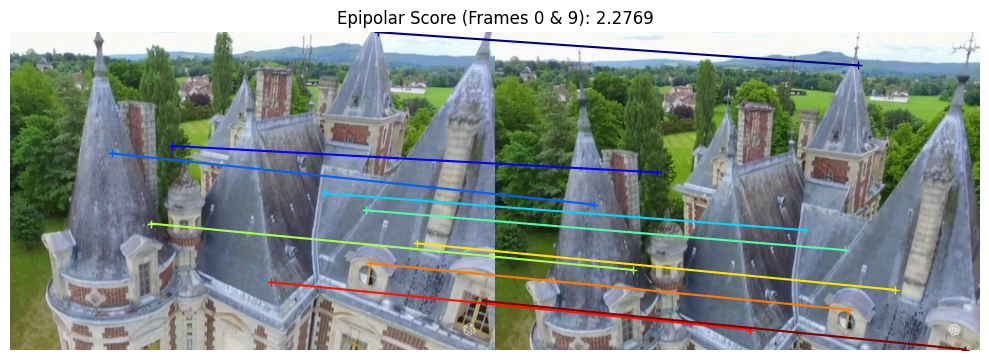

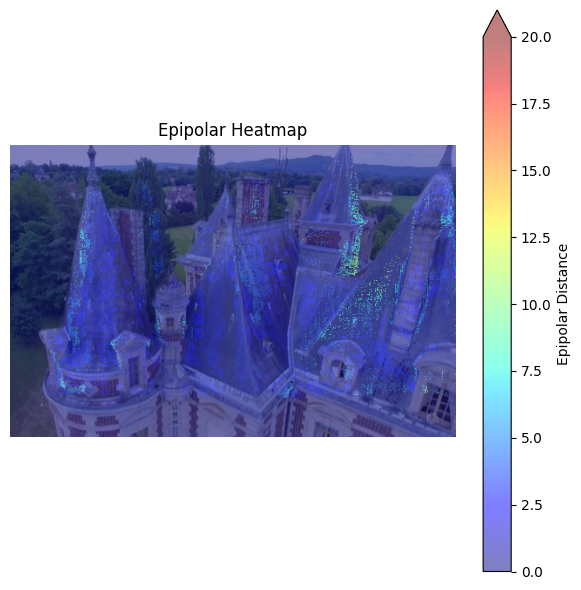

2.2769013471483412


In [23]:
castle_fake_score = run_multi_frame_epipolar_analysis(
    video_path="videos/fake_1.mp4",
    frame_indices=np.arange(100, 120, 2), # Select the frames used for the Dust3r 3D model
    idx_pair=(0, 9), # Select the frames that are compared
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(castle_fake_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 10 images
 - adding frames/frame100.png with resolution 1982x1044 --> 512x256
 - adding frames/frame102.png with resolution 1982x1044 --> 512x256
 - adding frames/frame104.png with resolution 1982x1044 --> 512x256
 - adding frames/frame106.png with resolution 1982x1044 --> 512x256
 - adding frames/frame108.png with resolution 1982x1044 --> 512x256
 - adding frames/frame110.png with resolution 1982x1044 --> 512x25

100%|██████████| 90/90 [00:54<00:00,  1.66it/s]


 init edge (9*,0*) score=np.float64(98.27240753173828)
 init edge (8*,0) score=np.float64(97.793701171875)
 init edge (9,1*) score=np.float64(96.38701629638672)
 init edge (7*,0) score=np.float64(96.28446197509766)
 init edge (6*,0) score=np.float64(93.08544158935547)
 init edge (9,2*) score=np.float64(92.07903289794922)
 init edge (9,3*) score=np.float64(91.18470001220703)
 init edge (9,5*) score=np.float64(89.12239837646484)
 init edge (9,4*) score=np.float64(88.29325103759766)
 init loss = 0.052569836378097534
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:30<00:00,  3.24it/s, lr=1.24647e-06 loss=0.0209549]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipyk

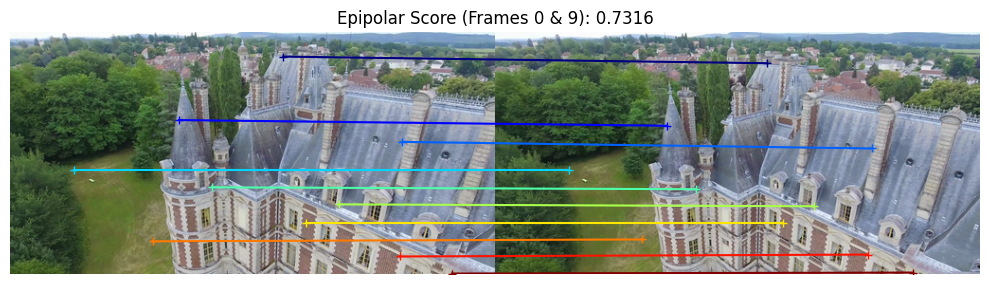

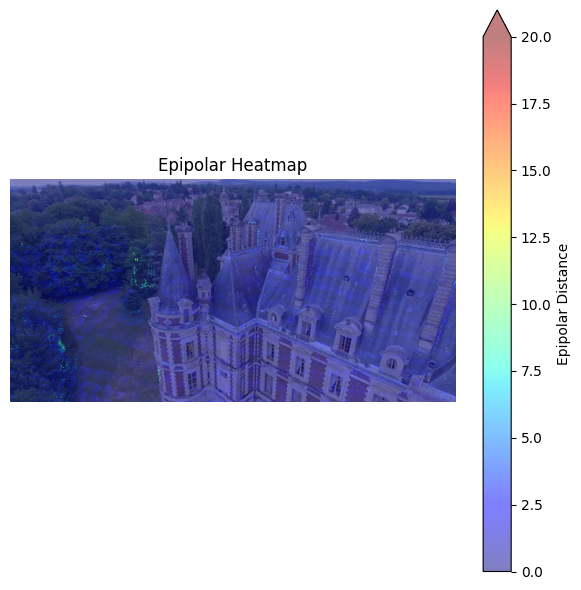

0.7315588473761038


In [24]:
castle_real_score = run_multi_frame_epipolar_analysis(
    video_path="videos/real_1.mp4",
    frame_indices=np.arange(100, 120, 2),
    idx_pair=(0, 9),
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(castle_real_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 10 images
 - adding frames/frame100.png with resolution 1280x720 --> 512x288
 - adding frames/frame102.png with resolution 1280x720 --> 512x288
 - adding frames/frame104.png with resolution 1280x720 --> 512x288
 - adding frames/frame106.png with resolution 1280x720 --> 512x288
 - adding frames/frame108.png with resolution 1280x720 --> 512x288
 - adding frames/frame110.png with resolution 1280x720 --> 512x288
 - a

  0%|          | 0/90 [00:00<?, ?it/s]/Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|██████████| 90/90 [

 init edge (0*,8*) score=np.float64(62.4052848815918)
 init edge (0,9*) score=np.float64(62.119686126708984)
 init edge (0,6*) score=np.float64(61.81802749633789)
 init edge (2*,8) score=np.float64(61.731449127197266)
 init edge (0,7*) score=np.float64(61.52766418457031)
 init edge (3*,8) score=np.float64(61.33855438232422)
 init edge (1*,8) score=np.float64(60.96382522583008)
 init edge (0,4*) score=np.float64(60.794979095458984)
 init edge (0,5*) score=np.float64(60.211753845214844)
 init loss = 0.02650858461856842
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:38<00:00,  2.57it/s, lr=1.24647e-06 loss=0.0160897]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T

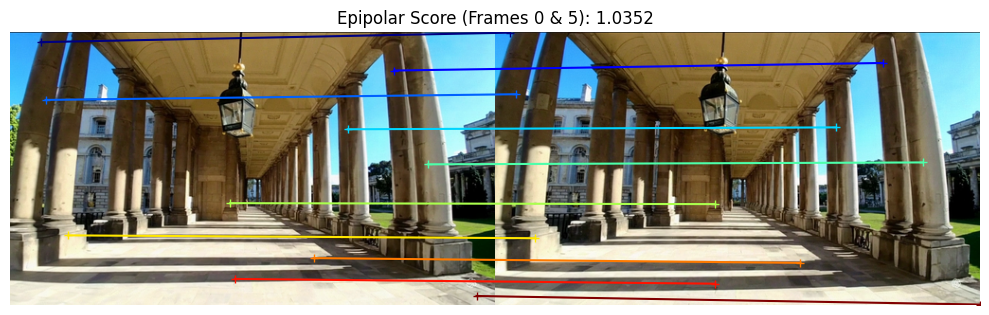

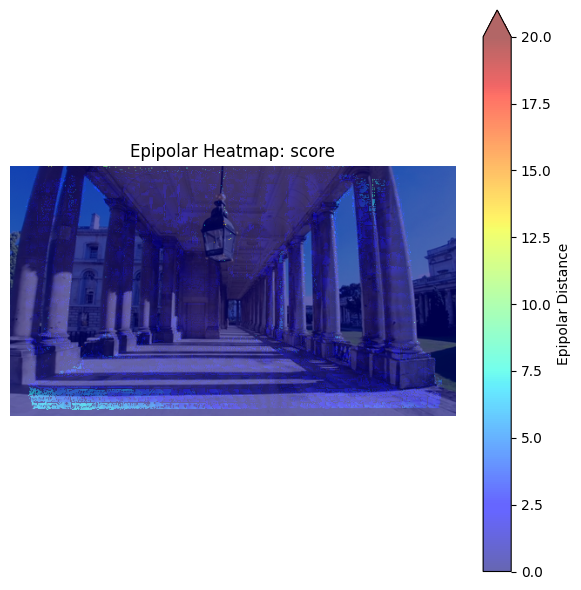

1.035202566412023


In [77]:
pillar_fake_score = run_multi_frame_epipolar_analysis(
    video_path="videos/fake_2.mp4",
    frame_indices=np.arange(100, 120, 2),
    idx_pair=(0, 5),
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(pillar_fake_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 10 images
 - adding frames/frame100.png with resolution 1982x1044 --> 512x256
 - adding frames/frame102.png with resolution 1982x1044 --> 512x256
 - adding frames/frame104.png with resolution 1982x1044 --> 512x256
 - adding frames/frame106.png with resolution 1982x1044 --> 512x256
 - adding frames/frame108.png with resolution 1982x1044 --> 512x256
 - adding frames/frame110.png with resolution 1982x1044 --> 512x25

100%|██████████| 90/90 [12:53<00:00,  8.60s/it] 


 init edge (1*,5*) score=np.float64(69.37548065185547)
 init edge (0*,5) score=np.float64(69.33277130126953)
 init edge (0,6*) score=np.float64(69.06629943847656)
 init edge (1,4*) score=np.float64(68.7628173828125)
 init edge (0,7*) score=np.float64(68.41781616210938)
 init edge (0,2*) score=np.float64(68.34156036376953)
 init edge (0,9*) score=np.float64(68.08084869384766)
 init edge (0,3*) score=np.float64(68.07002258300781)
 init edge (8*,1) score=np.float64(67.94611358642578)
 init loss = 0.02230903133749962
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:45<00:00,  2.19it/s, lr=1.24647e-06 loss=0.0131217]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T

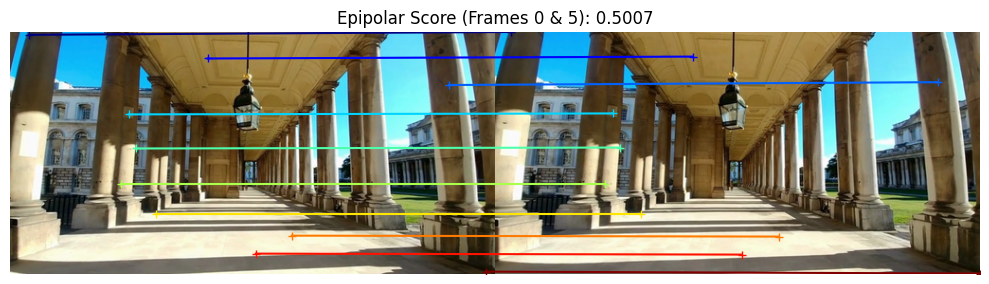

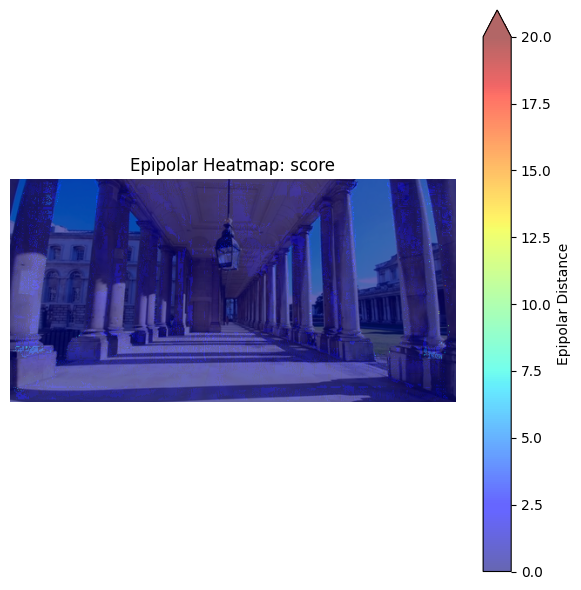

0.5007081530805295


In [78]:
pillar_real_score = run_multi_frame_epipolar_analysis(
    video_path="videos/real_2.mp4",
    frame_indices=np.arange(100, 120, 2),
    idx_pair=(0, 5),
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(pillar_real_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 6 images
 - adding frames/frame50.png with resolution 1280x720 --> 512x288
 - adding frames/frame52.png with resolution 1280x720 --> 512x288
 - adding frames/frame54.png with resolution 1280x720 --> 512x288
 - adding frames/frame56.png with resolution 1280x720 --> 512x288
 - adding frames/frame58.png with resolution 1280x720 --> 512x288
 - adding frames/frame60.png with resolution 1280x720 --> 512x288
 (Found 6 i

100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


 init edge (0*,5*) score=np.float64(8.31477165222168)
 init edge (0,3*) score=np.float64(8.13444709777832)
 init edge (0,4*) score=np.float64(7.97913122177124)
 init edge (0,1*) score=np.float64(7.898371696472168)
 init edge (0,2*) score=np.float64(7.5611443519592285)
 init loss = 0.02114253118634224
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:21<00:00,  4.62it/s, lr=1.24647e-06 loss=0.0100053]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T

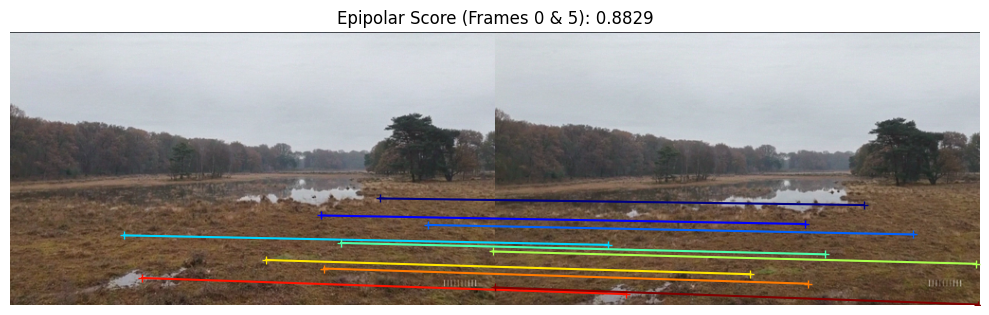

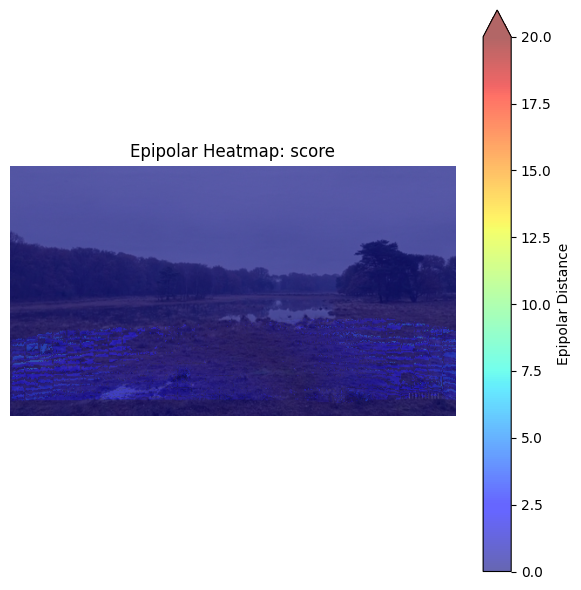

0.8829492698903078


In [83]:
lake_fake_score = run_multi_frame_epipolar_analysis(
    video_path="videos/fake_3.mp4",
    frame_indices=np.arange(50, 62, 2),
    idx_pair=(0, 5),
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(lake_fake_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 6 images
 - adding frames/frame50.png with resolution 1982x1044 --> 512x256
 - adding frames/frame52.png with resolution 1982x1044 --> 512x256
 - adding frames/frame54.png with resolution 1982x1044 --> 512x256
 - adding frames/frame56.png with resolution 1982x1044 --> 512x256
 - adding frames/frame58.png with resolution 1982x1044 --> 512x256
 - adding frames/frame60.png with resolution 1982x1044 --> 512x256
 (Fou

100%|██████████| 30/30 [01:40<00:00,  3.36s/it]


 init edge (5*,2*) score=np.float64(11.014703750610352)
 init edge (3*,2) score=np.float64(10.963489532470703)
 init edge (4*,3) score=np.float64(10.816739082336426)
 init edge (2,1*) score=np.float64(10.647774696350098)
 init edge (2,0*) score=np.float64(10.555877685546875)
 init loss = 0.033327557146549225
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:23<00:00,  4.25it/s, lr=1.24647e-06 loss=0.0216379]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/2686929268.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T

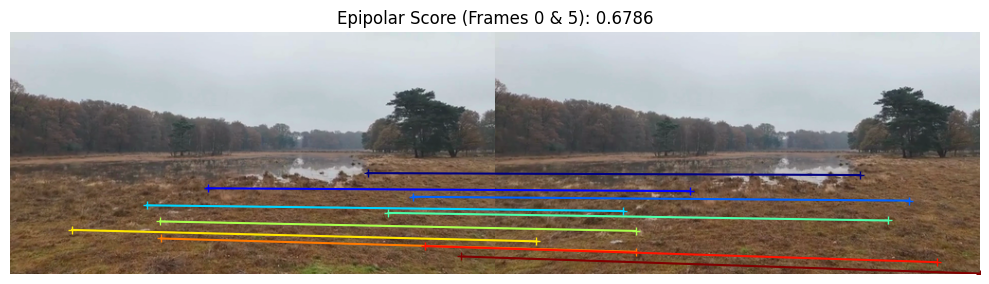

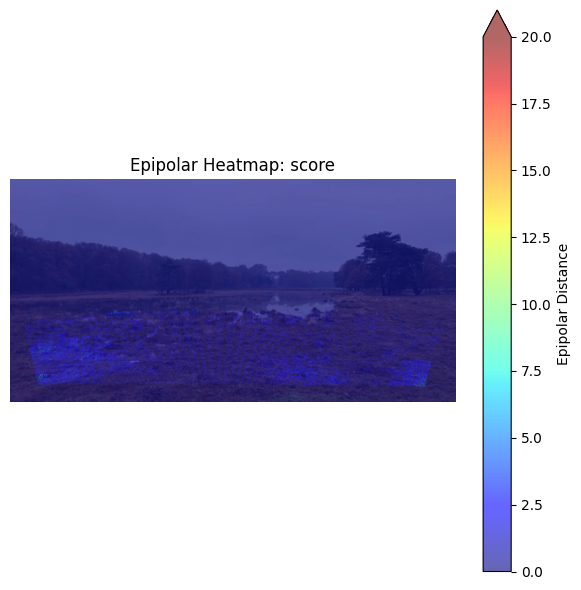

0.678585696670626


In [84]:
lake_real_score = run_multi_frame_epipolar_analysis(
    video_path="videos/real_3.mp4",
    frame_indices=np.arange(50, 62, 2),
    idx_pair=(0, 5),
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(lake_real_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 10 images
 - adding frames/frame40.png with resolution 1280x720 --> 512x288
 - adding frames/frame42.png with resolution 1280x720 --> 512x288
 - adding frames/frame44.png with resolution 1280x720 --> 512x288
 - adding frames/frame46.png with resolution 1280x720 --> 512x288
 - adding frames/frame48.png with resolution 1280x720 --> 512x288
 - adding frames/frame50.png with resolution 1280x720 --> 512x288
 - adding 

100%|██████████| 90/90 [01:41<00:00,  1.13s/it]


 init edge (5*,7*) score=np.float64(5.788774013519287)
 init edge (4*,7) score=np.float64(5.787941932678223)
 init edge (4,6*) score=np.float64(5.765924453735352)
 init edge (5,3*) score=np.float64(5.7185187339782715)
 init edge (5,2*) score=np.float64(5.705789566040039)
 init edge (5,8*) score=np.float64(5.694543838500977)
 init edge (5,9*) score=np.float64(5.663373947143555)
 init edge (5,0*) score=np.float64(5.531707763671875)
 init edge (5,1*) score=np.float64(5.51016092300415)
 init loss = 0.016906438395380974
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:40<00:00,  2.49it/s, lr=1.24647e-06 loss=0.00866132]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipy

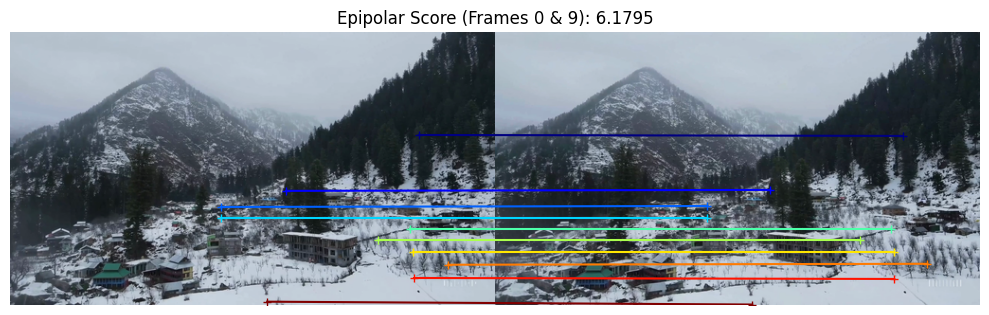

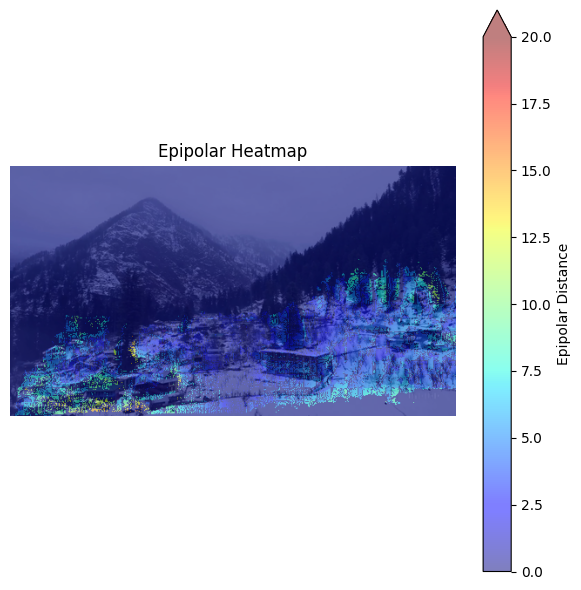

6.179475138626068


In [69]:
snow_fake_score = run_multi_frame_epipolar_analysis(
    video_path="videos/fake_4.mp4",
    frame_indices=np.arange(40, 60, 2),
    idx_pair=(0, 9),
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(snow_fake_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 10 images
 - adding frames/frame40.png with resolution 1920x1080 --> 512x288
 - adding frames/frame42.png with resolution 1920x1080 --> 512x288
 - adding frames/frame44.png with resolution 1920x1080 --> 512x288
 - adding frames/frame46.png with resolution 1920x1080 --> 512x288
 - adding frames/frame48.png with resolution 1920x1080 --> 512x288
 - adding frames/frame50.png with resolution 1920x1080 --> 512x288
 - a

100%|██████████| 90/90 [02:17<00:00,  1.53s/it]


 init edge (1*,0*) score=np.float64(7.5545549392700195)
 init edge (9*,0) score=np.float64(5.792621612548828)
 init edge (9,5*) score=np.float64(5.786296367645264)
 init edge (9,2*) score=np.float64(5.78469705581665)
 init edge (9,3*) score=np.float64(5.763086318969727)
 init edge (9,4*) score=np.float64(5.761305332183838)
 init edge (8*,0) score=np.float64(5.761087894439697)
 init edge (7*,0) score=np.float64(5.757653713226318)
 init edge (9,6*) score=np.float64(5.7243146896362305)
 init loss = 0.37515488266944885
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:39<00:00,  2.56it/s, lr=1.24647e-06 loss=0.32963]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_9945/358438385.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipyker

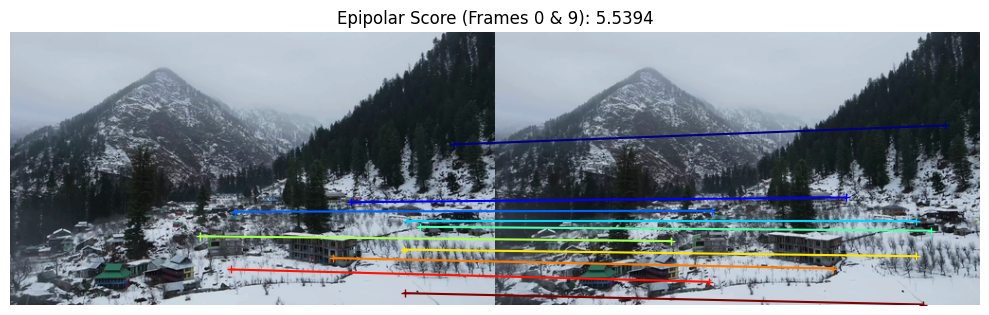

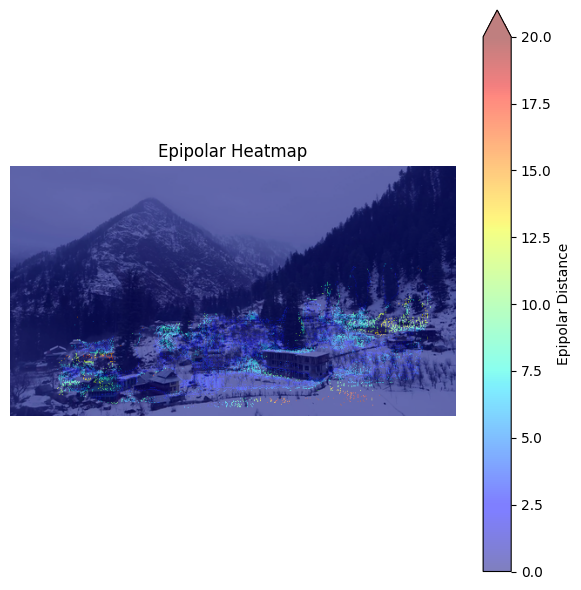

5.5393718651151245


In [70]:

snow_real_score = run_multi_frame_epipolar_analysis(
    video_path="videos/real_4.mp4",
    frame_indices=np.arange(40, 60, 2),
    idx_pair=(0, 9),
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(snow_real_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 6 images
 - adding frames/frame100.png with resolution 854x480 --> 512x288
 - adding frames/frame102.png with resolution 854x480 --> 512x288
 - adding frames/frame104.png with resolution 854x480 --> 512x288
 - adding frames/frame106.png with resolution 854x480 --> 512x288
 - adding frames/frame108.png with resolution 854x480 --> 512x288
 - adding frames/frame110.png with resolution 854x480 --> 512x288
 (Found 6 i

100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


 init edge (5*,4*) score=np.float64(5.372060298919678)
 init edge (4,2*) score=np.float64(5.150389194488525)
 init edge (3*,2) score=np.float64(5.130439281463623)
 init edge (2,1*) score=np.float64(5.0434346199035645)
 init edge (1,0*) score=np.float64(4.936027526855469)
 init loss = 0.015060094185173512
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:11<00:00,  8.67it/s, lr=1.24647e-06 loss=0.00909291]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch00

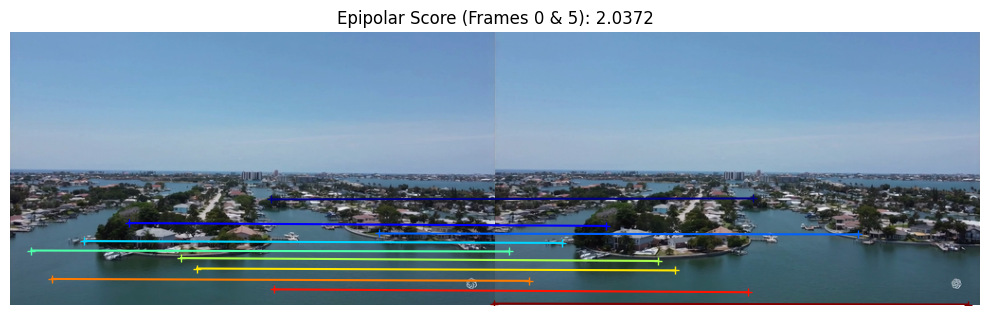

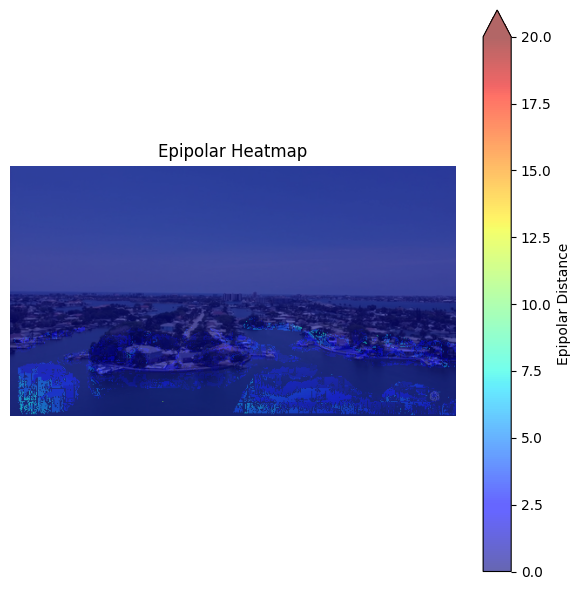

2.037196999877189


In [20]:
paradise_fake_score = run_multi_frame_epipolar_analysis(
    video_path="videos/fake_5.mp4",
    frame_indices=np.arange(100, 112, 2),
    idx_pair=(0, 5),
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(paradise_fake_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 6 images
 - adding frames/frame100.png with resolution 1920x1080 --> 512x288
 - adding frames/frame102.png with resolution 1920x1080 --> 512x288
 - adding frames/frame104.png with resolution 1920x1080 --> 512x288
 - adding frames/frame106.png with resolution 1920x1080 --> 512x288
 - adding frames/frame108.png with resolution 1920x1080 --> 512x288
 - adding frames/frame110.png with resolution 1920x1080 --> 512x288

100%|██████████| 30/30 [00:19<00:00,  1.54it/s]


 init edge (0*,5*) score=np.float64(4.3314642906188965)
 init edge (1*,5) score=np.float64(4.317515850067139)
 init edge (0,4*) score=np.float64(4.258754730224609)
 init edge (3*,1) score=np.float64(4.235579490661621)
 init edge (2*,5) score=np.float64(4.198407173156738)
 init loss = 0.014496030285954475
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:11<00:00,  8.68it/s, lr=1.24647e-06 loss=0.00782314]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch00

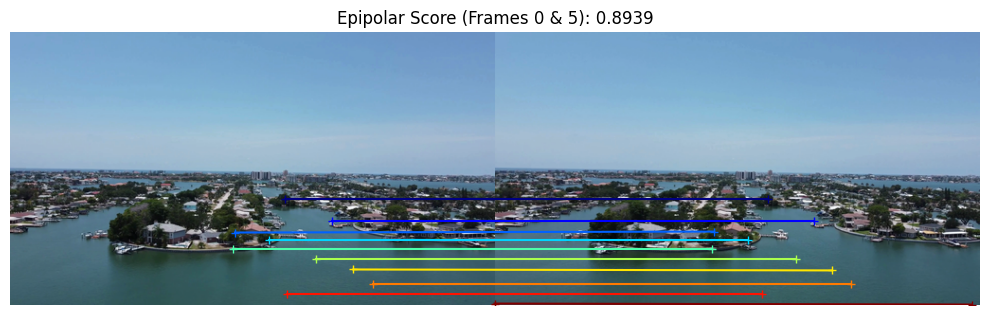

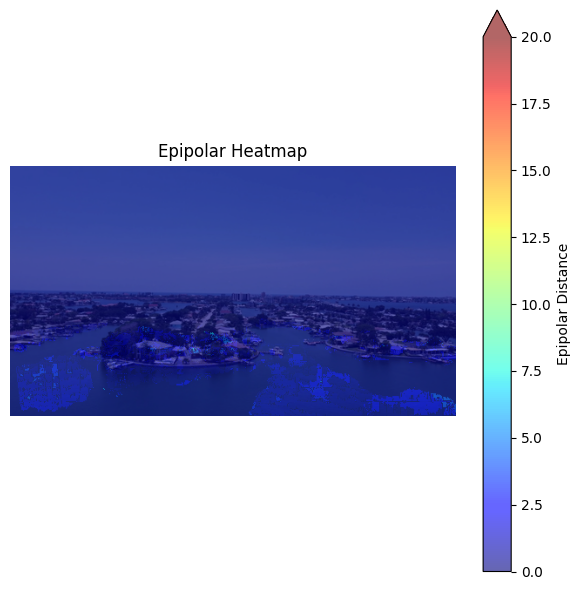

0.8939339669224504


In [21]:
paradise_real_score = run_multi_frame_epipolar_analysis(
    video_path="videos/real_5.mp4",
    frame_indices=np.arange(100, 112, 2), 
    idx_pair=(0, 5), 
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=1,
    niter=100,
    schedule="cosine",
    lr=0.001
)
print(paradise_real_score)

... loading model from /Volumes/HomeX/Users/yitjunyam_1/Documents/School/UVA/Master_AI/Computer_Vision_2/epipolar_inconsistency/dust3r-main/naver/DUSt3R_ViTLarge_BaseDecoder_512_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
Processing video 1/10...
>> Loading a list of 10 images
 - adding frames/frame100.png with resolution 1982x1044 --> 512x256
 - adding frames/frame102.png with resolution 1982x1044 --> 512x256
 - adding frames/frame104.png with resolution 1982x1044 --> 512x256
 - adding frames/frame106.png with resolution 1982x1044 --> 512x256
 - adding frames/frame108.png with resolution 1982x1044 --> 512x256
 - adding frames/frame110.png with resolu

100%|██████████| 45/45 [00:52<00:00,  1.17s/it]


 init edge (9*,0*) score=np.float64(98.27240753173828)
 init edge (8*,0) score=np.float64(97.793701171875)
 init edge (9,1*) score=np.float64(96.38701629638672)
 init edge (7*,0) score=np.float64(96.28446197509766)
 init edge (6*,0) score=np.float64(93.08544158935547)
 init edge (9,2*) score=np.float64(92.07903289794922)
 init edge (9,3*) score=np.float64(91.18470001220703)
 init edge (9,5*) score=np.float64(89.12239837646484)
 init edge (9,4*) score=np.float64(88.29325103759766)
 init loss = 0.052569836378097534
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:29<00:00,  3.44it/s, lr=1.24647e-06 loss=0.0209549]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:85: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:85: RuntimeWarning: overflow encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:85: RuntimeWarning: invalid value encountered in matmul
  lines_in_im1 = (F @ matches_im0_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:86: RuntimeWarning: divide by zero encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/2363081802.py:86: RuntimeWarning: overflow encountered in matmul
  lines_in_im0 = (F.T @ matches_im1_h.T).T
/var/folders/z0/p7__9ch5065gxvjjprl0csch000

Processing video 2/10...
>> Loading a list of 10 images
 - adding frames/frame100.png with resolution 1982x1044 --> 512x256
 - adding frames/frame102.png with resolution 1982x1044 --> 512x256
 - adding frames/frame104.png with resolution 1982x1044 --> 512x256
 - adding frames/frame106.png with resolution 1982x1044 --> 512x256
 - adding frames/frame108.png with resolution 1982x1044 --> 512x256
 - adding frames/frame110.png with resolution 1982x1044 --> 512x256
 - adding frames/frame112.png with resolution 1982x1044 --> 512x256
 - adding frames/frame114.png with resolution 1982x1044 --> 512x256
 - adding frames/frame116.png with resolution 1982x1044 --> 512x256
 - adding frames/frame118.png with resolution 1982x1044 --> 512x256
 (Found 10 images)
>> Inference with model on 90 image pairs


100%|██████████| 45/45 [00:51<00:00,  1.13s/it]


 init edge (1*,5*) score=np.float64(69.37548065185547)
 init edge (0*,5) score=np.float64(69.33277130126953)
 init edge (0,6*) score=np.float64(69.06629943847656)
 init edge (1,4*) score=np.float64(68.7628173828125)
 init edge (0,7*) score=np.float64(68.41781616210938)
 init edge (0,2*) score=np.float64(68.34156036376953)
 init edge (0,9*) score=np.float64(68.08084869384766)
 init edge (0,3*) score=np.float64(68.07002258300781)
 init edge (8*,1) score=np.float64(67.94611358642578)
 init loss = 0.02230903133749962
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:29<00:00,  3.39it/s, lr=1.24647e-06 loss=0.0131217]


Processing video 3/10...
>> Loading a list of 6 images
 - adding frames/frame50.png with resolution 1982x1044 --> 512x256
 - adding frames/frame52.png with resolution 1982x1044 --> 512x256
 - adding frames/frame54.png with resolution 1982x1044 --> 512x256
 - adding frames/frame56.png with resolution 1982x1044 --> 512x256
 - adding frames/frame58.png with resolution 1982x1044 --> 512x256
 - adding frames/frame60.png with resolution 1982x1044 --> 512x256
 (Found 6 images)
>> Inference with model on 30 image pairs


100%|██████████| 15/15 [00:17<00:00,  1.14s/it]


 init edge (5*,2*) score=np.float64(11.014703750610352)
 init edge (3*,2) score=np.float64(10.963489532470703)
 init edge (4*,3) score=np.float64(10.816739082336426)
 init edge (2,1*) score=np.float64(10.647774696350098)
 init edge (2,0*) score=np.float64(10.555877685546875)
 init loss = 0.033327557146549225
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:10<00:00,  9.40it/s, lr=1.24647e-06 loss=0.0216379]


Processing video 4/10...
>> Loading a list of 10 images
 - adding frames/frame40.png with resolution 1920x1080 --> 512x288
 - adding frames/frame42.png with resolution 1920x1080 --> 512x288
 - adding frames/frame44.png with resolution 1920x1080 --> 512x288
 - adding frames/frame46.png with resolution 1920x1080 --> 512x288
 - adding frames/frame48.png with resolution 1920x1080 --> 512x288
 - adding frames/frame50.png with resolution 1920x1080 --> 512x288
 - adding frames/frame52.png with resolution 1920x1080 --> 512x288
 - adding frames/frame54.png with resolution 1920x1080 --> 512x288
 - adding frames/frame56.png with resolution 1920x1080 --> 512x288
 - adding frames/frame58.png with resolution 1920x1080 --> 512x288
 (Found 10 images)
>> Inference with model on 90 image pairs


100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


 init edge (9*,0*) score=np.float64(5.792621612548828)
 init edge (9,5*) score=np.float64(5.786296367645264)
 init edge (9,2*) score=np.float64(5.78469705581665)
 init edge (9,1*) score=np.float64(5.781079292297363)
 init edge (9,3*) score=np.float64(5.763086318969727)
 init edge (9,4*) score=np.float64(5.761305332183838)
 init edge (8*,0) score=np.float64(5.761087894439697)
 init edge (7*,0) score=np.float64(5.757653713226318)
 init edge (9,6*) score=np.float64(5.7243146896362305)
 init loss = 0.045613616704940796
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:34<00:00,  2.93it/s, lr=1.24647e-06 loss=0.0205277]


Processing video 5/10...
>> Loading a list of 6 images
 - adding frames/frame100.png with resolution 1920x1080 --> 512x288
 - adding frames/frame102.png with resolution 1920x1080 --> 512x288
 - adding frames/frame104.png with resolution 1920x1080 --> 512x288
 - adding frames/frame106.png with resolution 1920x1080 --> 512x288
 - adding frames/frame108.png with resolution 1920x1080 --> 512x288
 - adding frames/frame110.png with resolution 1920x1080 --> 512x288
 (Found 6 images)
>> Inference with model on 30 image pairs


100%|██████████| 15/15 [00:19<00:00,  1.31s/it]


 init edge (0*,5*) score=np.float64(4.3314642906188965)
 init edge (1*,5) score=np.float64(4.317515850067139)
 init edge (0,4*) score=np.float64(4.258754730224609)
 init edge (3*,1) score=np.float64(4.235579490661621)
 init edge (2*,5) score=np.float64(4.198407173156738)
 init loss = 0.014496030285954475
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:11<00:00,  8.59it/s, lr=1.24647e-06 loss=0.00782314]


Processing video 6/10...
>> Loading a list of 10 images
 - adding frames/frame100.png with resolution 720x480 --> 512x336
 - adding frames/frame102.png with resolution 720x480 --> 512x336
 - adding frames/frame104.png with resolution 720x480 --> 512x336
 - adding frames/frame106.png with resolution 720x480 --> 512x336
 - adding frames/frame108.png with resolution 720x480 --> 512x336
 - adding frames/frame110.png with resolution 720x480 --> 512x336
 - adding frames/frame112.png with resolution 720x480 --> 512x336
 - adding frames/frame114.png with resolution 720x480 --> 512x336
 - adding frames/frame116.png with resolution 720x480 --> 512x336
 - adding frames/frame118.png with resolution 720x480 --> 512x336
 (Found 10 images)
>> Inference with model on 90 image pairs


100%|██████████| 45/45 [01:09<00:00,  1.55s/it]


 init edge (9*,0*) score=np.float64(41.95038986206055)
 init edge (8*,0) score=np.float64(38.703487396240234)
 init edge (6*,0) score=np.float64(37.59874725341797)
 init edge (7*,0) score=np.float64(35.66515350341797)
 init edge (9,1*) score=np.float64(34.83488082885742)
 init edge (9,2*) score=np.float64(33.897674560546875)
 init edge (9,3*) score=np.float64(31.18108558654785)
 init edge (5*,0) score=np.float64(30.83513069152832)
 init edge (4*,0) score=np.float64(30.6162052154541)
 init loss = 0.057819172739982605
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:39<00:00,  2.55it/s, lr=1.24647e-06 loss=0.0349789]


Processing video 7/10...
>> Loading a list of 10 images
 - adding frames/frame100.png with resolution 1280x720 --> 512x288
 - adding frames/frame102.png with resolution 1280x720 --> 512x288
 - adding frames/frame104.png with resolution 1280x720 --> 512x288
 - adding frames/frame106.png with resolution 1280x720 --> 512x288
 - adding frames/frame108.png with resolution 1280x720 --> 512x288
 - adding frames/frame110.png with resolution 1280x720 --> 512x288
 - adding frames/frame112.png with resolution 1280x720 --> 512x288
 - adding frames/frame114.png with resolution 1280x720 --> 512x288
 - adding frames/frame116.png with resolution 1280x720 --> 512x288
 - adding frames/frame118.png with resolution 1280x720 --> 512x288
 (Found 10 images)
>> Inference with model on 90 image pairs


100%|██████████| 45/45 [01:00<00:00,  1.35s/it]


 init edge (0*,8*) score=np.float64(62.4052848815918)
 init edge (0,9*) score=np.float64(62.119686126708984)
 init edge (0,6*) score=np.float64(61.81802749633789)
 init edge (2*,8) score=np.float64(61.731449127197266)
 init edge (0,7*) score=np.float64(61.52766418457031)
 init edge (3*,8) score=np.float64(61.33855438232422)
 init edge (1*,8) score=np.float64(60.96382522583008)
 init edge (0,4*) score=np.float64(60.794979095458984)
 init edge (0,5*) score=np.float64(60.211753845214844)
 init loss = 0.02650858461856842
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:35<00:00,  2.80it/s, lr=1.24647e-06 loss=0.0160897]


Processing video 8/10...
>> Loading a list of 6 images
 - adding frames/frame50.png with resolution 1280x720 --> 512x288
 - adding frames/frame52.png with resolution 1280x720 --> 512x288
 - adding frames/frame54.png with resolution 1280x720 --> 512x288
 - adding frames/frame56.png with resolution 1280x720 --> 512x288
 - adding frames/frame58.png with resolution 1280x720 --> 512x288
 - adding frames/frame60.png with resolution 1280x720 --> 512x288
 (Found 6 images)
>> Inference with model on 30 image pairs


100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


 init edge (0*,5*) score=np.float64(8.31477165222168)
 init edge (0,3*) score=np.float64(8.13444709777832)
 init edge (0,4*) score=np.float64(7.97913122177124)
 init edge (0,1*) score=np.float64(7.898371696472168)
 init edge (0,2*) score=np.float64(7.5611443519592285)
 init loss = 0.02114253118634224
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:12<00:00,  8.12it/s, lr=1.24647e-06 loss=0.0100053]


Processing video 9/10...
>> Loading a list of 10 images
 - adding frames/frame40.png with resolution 1280x720 --> 512x288
 - adding frames/frame42.png with resolution 1280x720 --> 512x288
 - adding frames/frame44.png with resolution 1280x720 --> 512x288
 - adding frames/frame46.png with resolution 1280x720 --> 512x288
 - adding frames/frame48.png with resolution 1280x720 --> 512x288
 - adding frames/frame50.png with resolution 1280x720 --> 512x288
 - adding frames/frame52.png with resolution 1280x720 --> 512x288
 - adding frames/frame54.png with resolution 1280x720 --> 512x288
 - adding frames/frame56.png with resolution 1280x720 --> 512x288
 - adding frames/frame58.png with resolution 1280x720 --> 512x288
 (Found 10 images)
>> Inference with model on 90 image pairs


100%|██████████| 45/45 [00:59<00:00,  1.31s/it]


 init edge (5*,7*) score=np.float64(5.788774013519287)
 init edge (4*,7) score=np.float64(5.787941932678223)
 init edge (4,6*) score=np.float64(5.765924453735352)
 init edge (5,3*) score=np.float64(5.7185187339782715)
 init edge (5,2*) score=np.float64(5.705789566040039)
 init edge (5,8*) score=np.float64(5.694543838500977)
 init edge (5,9*) score=np.float64(5.663373947143555)
 init edge (5,0*) score=np.float64(5.531707763671875)
 init edge (5,1*) score=np.float64(5.51016092300415)
 init loss = 0.01595113053917885
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:33<00:00,  2.95it/s, lr=1.24647e-06 loss=0.00784046]


Processing video 10/10...
>> Loading a list of 6 images
 - adding frames/frame100.png with resolution 854x480 --> 512x288
 - adding frames/frame102.png with resolution 854x480 --> 512x288
 - adding frames/frame104.png with resolution 854x480 --> 512x288
 - adding frames/frame106.png with resolution 854x480 --> 512x288
 - adding frames/frame108.png with resolution 854x480 --> 512x288
 - adding frames/frame110.png with resolution 854x480 --> 512x288
 (Found 6 images)
>> Inference with model on 30 image pairs


100%|██████████| 15/15 [00:19<00:00,  1.30s/it]


 init edge (5*,4*) score=np.float64(5.372060298919678)
 init edge (4,2*) score=np.float64(5.150389194488525)
 init edge (3*,2) score=np.float64(5.130439281463623)
 init edge (2,1*) score=np.float64(5.0434346199035645)
 init edge (1,0*) score=np.float64(4.936027526855469)
 init loss = 0.015060094185173512
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 100/100 [00:11<00:00,  8.62it/s, lr=1.24647e-06 loss=0.00909291]
/var/folders/z0/p7__9ch5065gxvjjprl0csch0000gn/T/ipykernel_39492/525665007.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.08, 0.05, 0.86, 0.92])


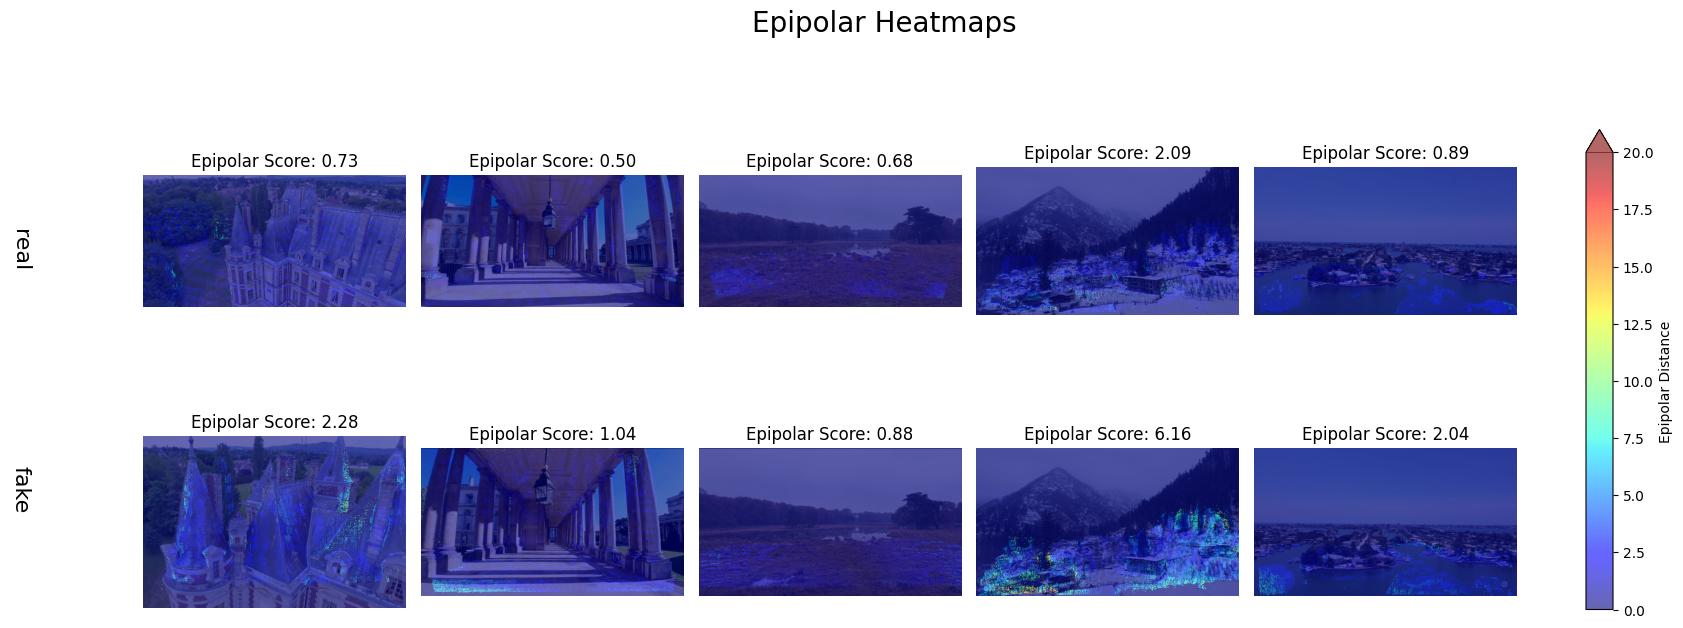

Saved grid of 10 epipolar heatmaps to 'epipolar_heatmaps_2x5.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
video_paths = ["videos/real_1.mp4", "videos/real_2.mp4", "videos/real_3.mp4", "videos/real_4.mp4", "videos/real_5.mp4", "videos/fake_1.mp4", "videos/fake_2.mp4", "videos/fake_3.mp4", "videos/fake_4.mp4", "videos/fake_5.mp4"]
frames_indices = [np.arange(100, 120, 2), np.arange(100, 120, 2), np.arange(50, 62, 2), np.arange(40, 60, 2), np.arange(100, 112, 2), np.arange(100, 120, 2), np.arange(100, 120, 2), np.arange(50, 62, 2),np.arange(40, 60, 2), np.arange(100, 112, 2)]
idx_pairs = [(0, 9), (0, 5), (0, 5), (0, 9), (0, 5), (0, 9), (0, 5), (0,5), (0, 9), (0,5)]

process_and_visualize_videos(
    video_paths=video_paths,
    frames_indices=frames_indices,
    idx_pairs=idx_pairs,
    model=AsymmetricCroCo3DStereo.from_pretrained(model_name).to(device),
    device=device,
    batch_size=2,
    niter=100,
    schedule="cosine",
    lr=0.001,
)